In [1]:
# load some libraries
import sys
import os
import pickle
import gzip
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts import metrics

from lib.gluformer.model import *
from lib.latent_ode.trainer_glunet import *
from utils.darts_processing import *
from utils.darts_dataset import *

In [2]:
# plots of uninterpolated glucose data for each patient
hall_formatter, hall_series, hall_scalers = load_data(seed=0, study_file=None, dataset='hall', use_covs=False, use_static_covs=True)
dubosson_formatter, dubosson_series, dubosson_scalers = load_data(seed=0, study_file=None, dataset='dubosson', use_covs=False, use_static_covs=True)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Dropping columns / rows...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		Age: REAL_VALUED (STATIC_INPUT)
		BMI: REAL_VALUED (STATIC_INPUT)
		A1C: REAL_VALUED (STATIC_INPUT)
		FBG: REAL_VALUED (STATIC_INPUT)
		ogtt.2hr: REAL_VALUED (STATIC_INPUT)
		insulin: REAL_VALUED (STATIC_INPUT)
		hs.CRP: REAL_VALUED (STATIC_INPUT)
		Tchol: REAL_VALUED (STATIC_INPUT)
		Trg: REAL_VALUED (STATIC_INPUT)
		HDL: REAL_VALUED (STATIC_INPUT)
		LDL: REAL_VALUED (STATIC_INPUT)
		mean_glucose: REAL_VALUED (STATIC_INPUT)
		sd_glucose: REAL_VALUED (STATIC_INPUT)
		range_glucose: REAL_VALUED (STATIC_INPUT)
		min_glucose: REAL_VALUED (STATIC_INPUT)
		max_glucose: REAL_VALUED (STATIC_INPUT)
		quartile.25_glucose: REAL_VALUED (STATIC_INPUT)
		median_glucose: REAL_VA

In [3]:
# Get example data
subject = hall_formatter.data.loc[hall_formatter.data['id'] == 1]
subject2 = dubosson_formatter.data.loc[dubosson_formatter.data['id'] == 1]
age = subject['Age'][:48].values
time = subject['time'][:48].values
hr = subject2['HR'][:48].values

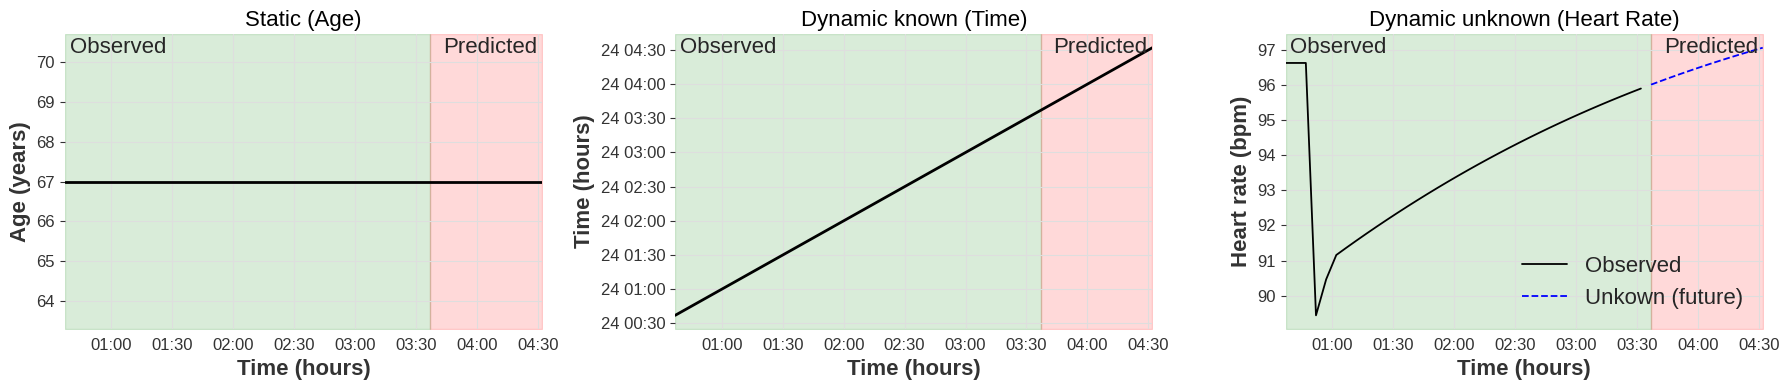

In [4]:
import matplotlib.dates as mdates
date_fmt = mdates.DateFormatter('%H:%M')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
plt.style.use('seaborn-whitegrid')

# Plot age
ax = axs[0]
ax.plot(time, age, color='black', linewidth=2)
ax.set_xlabel('Time (hours)', fontsize=16)
ax.set_ylabel('Age (years)', fontsize=16)
ax.set_title('Static (Age)', fontsize=16)
abs_min, abs_max = ax.get_ylim()
ax.fill_betweenx([abs_min, abs_max], x1 = time[0], x2 = time[36], color='green', alpha=0.15)
ax.fill_betweenx([abs_min, abs_max], x1 = time[36], x2 = time[47], color='red', alpha=0.15)
ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes, fontsize=16)
ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes, fontsize=16)


# Plot time
ax = axs[1]
ax.plot(time, time, color='black', linewidth=2)
ax.set_xlabel('Time (hours)', fontsize=16)
ax.set_ylabel('Time (hours)', fontsize=16)
ax.set_title('Dynamic known (Time)', fontsize=16)
abs_min, abs_max = ax.get_ylim()
ax.fill_betweenx([abs_min, abs_max], x1 = time[0], x2 = time[36], color='green', alpha=0.15)
ax.fill_betweenx([abs_min, abs_max], x1 = time[36], x2 = time[47], color='red', alpha=0.15)
ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes, fontsize=16)
ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes, fontsize=16)

# Plot time
ax = axs[2]
ax.plot(time[:36], hr[:36], label = 'Observed')
ax.plot(time[36:], hr[36:], color = 'blue', linestyle = '--', label = 'Unkown (future)')
ax.set_xlabel('Time (hours)', fontsize=16)
ax.set_ylabel('Heart rate (bpm)', fontsize=16)
ax.set_title('Dynamic unknown (Heart Rate)', fontsize=16)
abs_min, abs_max = ax.get_ylim()
ax.fill_betweenx([abs_min, abs_max], x1 = time[0], x2 = time[36], color='green', alpha=0.15)
ax.fill_betweenx([abs_min, abs_max], x1 = time[36], x2 = time[47], color='red', alpha=0.15)
ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes, fontsize=16)
ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes, fontsize=16)
ax.xaxis.set_major_formatter(date_fmt)
ax.margins(0)
ax.legend(loc='lower right', fontsize=16)

# Change font size
for ax in axs:
    ax.xaxis.set_major_formatter(date_fmt)
    ax.margins(0)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(16)
    for item in (ax.get_yticklabels() + ax.get_xticklabels()):
        item.set_fontsize(12)
        
# Save figure
plt.tight_layout()
plt.savefig('paper_results/plots/figure2.pdf', bbox_inches='tight')